
# Train a model on drug review dataset to predict the patient rating


In [64]:
import numpy as np
np.random.seed(27)
from decimal import Decimal
import time as tp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from string import punctuation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import os
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from sklearn.externals import joblib

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Apurva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#  DATA LOAD

In [65]:
# parameters to be used during DATA LOAD & EDA
param_EDA = {
        'train_file' : "C:/Users/Apurva/Desktop/CaseStudy/drugsCom_raw/drugsComTrain_raw.tsv" ,
        'test_file' : "C:/Users/Apurva/Desktop/CaseStudy/drugsCom_raw/drugsComTest_raw.tsv" 
        }

# loading tab seperated data
train_raw = pd.read_csv(param_EDA['train_file'], sep = "\t" )
test_raw = pd.read_csv(param_EDA['test_file'], sep = "\t" )

In [66]:
# Reviewing the dimention of both the datasets
print ( "train obs: ", train_raw.shape[0], "\ntest obs: ", test_raw.shape[0], "\nno of features: ", train_raw.shape[1] )
print (train_raw.dtypes , "\n" , train_raw.describe() )
print (train_raw.head())

train obs:  161297 
test obs:  53766 
no of features:  7
Unnamed: 0       int64
drugName        object
condition       object
review          object
rating         float64
date            object
usefulCount      int64
dtype: object 
           Unnamed: 0         rating    usefulCount
count  161297.000000  161297.000000  161297.000000
mean   115923.585305       6.994377      28.004755
std     67004.445170       3.272329      36.403742
min         2.000000       1.000000       0.000000
25%     58063.000000       5.000000       6.000000
50%    115744.000000       8.000000      16.000000
75%    173776.000000      10.000000      36.000000
max    232291.000000      10.000000    1291.000000
   Unnamed: 0                  drugName                     condition  \
0      206461                 Valsartan  Left Ventricular Dysfunction   
1       95260                Guanfacine                          ADHD   
2       92703                    Lybrel                 Birth Control   
3      138000  

#### Abstract: 
The drug review dataset has 6 variables (excluding the unique identifier).
    1. drugName (categorical): name of drug
    2. condition (categorical): name of condition
    3. review (text): patient review
    4. rating (numerical): 10 star patient rating
    5. date (date): date of review entry
    6. usefulCount (numerical): number of users who found review useful
The Training data has 160 thousand obervations and test has 50 thousand obervations. Both data has same variables.

# EDA

## Dependent variable ( rating ) 

In [67]:
print ( "Unique Value" , len(pd.unique(train_raw.rating)) , ";  and the average is", round ( Decimal ( np.average (train_raw.rating)),2) )

Unique Value 10 ;  and the average is 6.99


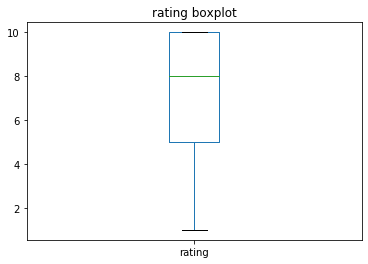

In [68]:
axes = train_raw['rating'].plot( kind = 'box', title = 'rating boxplot') 

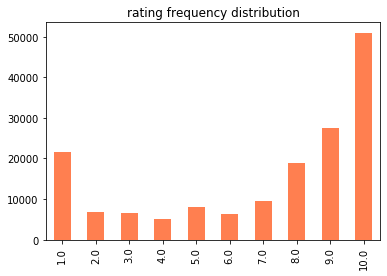

In [69]:
axes = train_raw['rating'].value_counts().sort_index().plot( kind = 'bar', title = 'rating frequency distribution',color="coral")

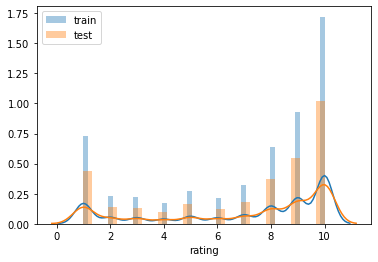

In [70]:
sns.distplot(train_raw['rating'] , label='train')
sns.distplot(test_raw['rating'], label='test')
plt.legend();

#### Abstract:
The Rating has 10 unique values (1 -10). The mean is ~7 and median ~8, which means that on an average the ratings are good than bad. 
The frequency distributional shows a bimodal nature, with 2 peaks at 1 & 10, that is customers provides review when either they have a positive or negative feedback. As expected peak at 10 is higher than at 1, hence more number of customer with positive view has provided their feedback.
The Distributiuon of rating between train and test is alike.

## Features (drugName, condition, usefulCount, date) 

### drugName

Text(0.5, 0, '% reviews')

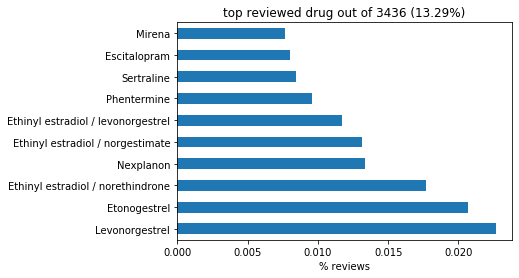

In [71]:
t = len(pd.unique(train_raw.drugName))
b = round ( Decimal (100* np.sum ( train_raw['drugName'].value_counts()[0:10]/len(train_raw) )) , 2)
axes = (train_raw['drugName'].value_counts()[0:10]/len(train_raw)).plot(kind = 'barh', title = 'top reviewed drug out of '+str(t)+" ("+str(b)+"%)")
axes.set_xlabel("% reviews")

#### Abstract:
Their are 3000+ unique drug names present in the training data. The top 10 is as shown in the above plot which encompasses 13% of the overall drug review.

### condition

Text(0.5, 0, '% reviews')

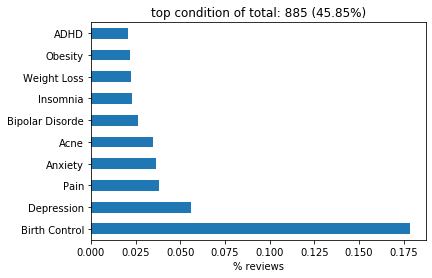

In [72]:
t = len(pd.unique(train_raw.condition))
b = round ( Decimal (100* np.sum ( train_raw['condition'].value_counts()[0:10]/len(train_raw) )) , 2)
axes = (train_raw['condition'].value_counts()[0:10]/len(train_raw)).plot(kind = 'barh', title = 'top condition of total: '+str(t)+" ("+str(b)+"%)")
axes.set_xlabel("% reviews")

#### Abstract:
Their are 800+ unique condition present in the training data. The top (based on highest frequency) one being Birth Control, which alone factors for 17% of the training data.
The top 10 condition can be seen in the above plot. It explains 46% of the entire training data, which means that just half the ratings are for other rest 875 conditions.

### usefulCount

           minimum:  0    maximum:  1291


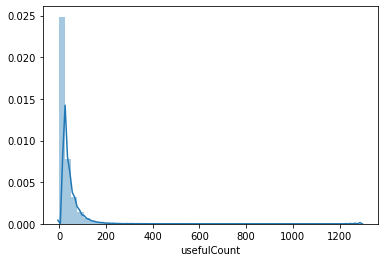

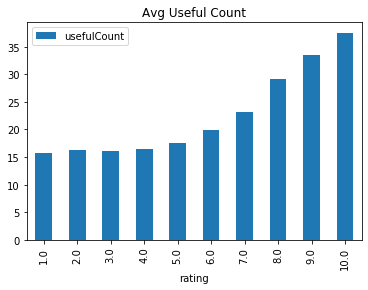

In [73]:
sns.distplot(train_raw['usefulCount'])
pd.pivot_table(train_raw, index='rating', values='usefulCount', aggfunc=np.average).plot( kind = 'bar',title = 'Avg Useful Count' )
print ( "           minimum: " , np.min (train_raw['usefulCount']), "   maximum: ", np.max (train_raw['usefulCount']))

#### Abstract:
The useful count feature has a minimum of 0 and maximum of 1291 value.
The avg useful count per rating is same across 1-5 but increases consistently from 6-10; this beahviour indicates that customers has found higher rating reviews more helpful.

### Date

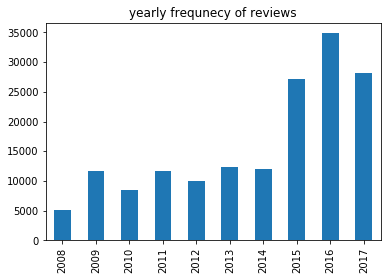

In [74]:
train_raw['datef'] = pd.to_datetime(train_raw.date, errors='coerce')
train_raw['datef'].dt.year.value_counts().sort_index().plot( kind = 'bar', title = 'yearly frequnecy of reviews' )

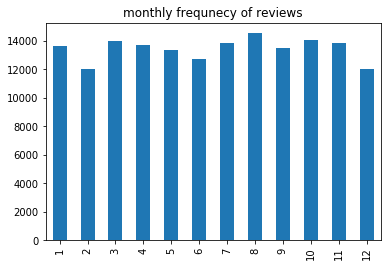

In [75]:
train_raw['datef'].dt.month.value_counts().sort_index().plot( kind = 'bar', title = 'monthly frequnecy of reviews' )

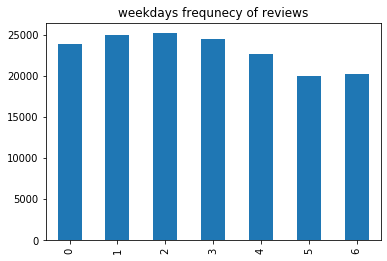

In [76]:
train_raw['datef'].dt.weekday.value_counts().sort_index().plot( kind = 'bar', title = 'weekdays frequnecy of reviews' )

#### Abstract:
Either more reviews has been collected during recent years (2015-2017)  or more customers has reviewed during these years.
The number of reviews vary slightly across the months.
The reviews are generated more during the weekdays as compared to weekends.

# DATA PROCESSING FOR MODEL

## Defining few helper functions for the data processing

#### Passing parameters required for data prep

In [77]:
param_prep = {
        'vocab_size' : 10000 ,
        'max_length' : 100 ,
        'stopwords_no' : set({ 'no', 'not', 'but', "haven't", "weren't", "wasn't", "doesn't", 'off',
                      "hadn't", "mightn't", "couldn't", "shan't", "mustn't", "isn't", "won't",
                      "needn't", "don't", "didn't", "shouldn't", "wouldn't", "hasn't" }),
        'oov_tok' : "<OOV>" ,
        'padding_type' : 'post',
        'trunc_type' : 'post'
        }

#### Helper function for changing the ratings from 10 level to 3 level
- The 10 level ratings has been converted to 3 level indicating the extent/sentiment of the rating.
    1-3: Demoter (identified as 0)
    4-7: Neutral (identified as 1)
    8-10: Promoter (identified as 2)

In [78]:
def change_y (rating):
    r1 = np.where ( rating < 4 , 0 , rating )
    r2 = np.where ( r1 > 7 , 2 , r1 )
    r3 = np.where ( r2 > 2 , 1  , r2 )
    return r3

#### Helper function for removing punctuation, stop words and stemming. 

- Removing Punctuation : Although punctuation can be automatically removed while using keras tokenizer, but since it was interacting with the stop words ( resulting in differnt words, eg 'it' vs '.it'), had to remove beforehand.
- Removing stop words : Only removing neutral ones and not ones with 'no' ;  as these embarks meaning to the sentence . List of retained stop words can be found with param_prep dcitionary.
- Stemming the sentence : It has 80,000 + unique words. The thought process is to remove duplicate words as much as possible to retain a unique set of 10,000 words at end. 
- Used PorterStemmer as it is older, less aggressive, simple and fast. 

In [79]:
def filter_punc_stop_stem_words ( train_sentences ):
    stop_words_sel = ( set(stopwords.words('english'))  - param_prep['stopwords_no'] )
    train_sentences2 = [ train_sentences[x].translate(str.maketrans('','', punctuation)) for x in range (len(train_sentences))]
    train_sentences3 = train_sentences2
    ps = PorterStemmer()
    for i, sen in enumerate(train_sentences2) :
        sent = [ ps.stem(w.lower()) for w in sen.split() if w.lower() not in stop_words_sel ]
        train_sentences3[i] = ' '.join(sent)
    return train_sentences3

#### Helper function to create data for auxilliary input to the model 

- Apart from the text review, feeding factors like drugname, condition, review date and useful count.
- Hence creating a seperate data for auxilliary input to layers of NN.

In [80]:
def aux_data ( tr ):
    tr_aux1 = tr[['usefulCount' ,  'date']]
    """
    tr_aux1['datef'] = pd.to_datetime(tr_aux1.date, errors='coerce')
    tr_aux1['date_year'] = tr_aux1['datef'].dt.year  
    tr_aux1['date_month'] = tr_aux1['datef'].dt.month
    tr_aux1['date_weekday'] = tr_aux1['datef'].dt.weekday
    """
    #tr_aux2 = pd.get_dummies(tr[ 'drugName' , condition'], prefix=['D', C'])
    #tr_ax = pd.concat([tr_aux1, tr_aux2], axis = 1 )             , 'datef'
    tr_ax = tr_aux1.drop(['date' ], axis = 1 )
    return tr_ax

## Training data: processing

In [81]:
# creating a list of all the reviews and subsequnetly removing punctuations and stopwords.
train_text = [x for x in train_raw.review]
train_text1 = filter_punc_stop_stem_words ( train_text )

# tokenizer
tokenizer = Tokenizer(num_words = param_prep['vocab_size'] , oov_token = param_prep['oov_tok'] )
tokenizer.fit_on_texts(train_text1)
# creating sequence of tokens
word_index = tokenizer.word_index
seq = tokenizer.texts_to_sequences(train_text1)
# padding
seq_padded = pad_sequences(seq, padding = 'post' , maxlen = param_prep['max_length'] , truncating = param_prep['trunc_type'] ) 


# creating the train_y data ( dependent variable dataset)
label3 = change_y(train_raw['rating']) 

# calling the auxilliary data creation helper function to create the aux input for training.
train_aux = aux_data (train_raw)

## Testing data: processing

In [82]:
# creating a list of all the reviews and subsequnetly removing punctuations and stopwords.
test_text = [x for x in test_raw.review]
test_text1 = filter_punc_stop_stem_words ( test_text )

# using the already trained tokenizer on test data
seq_test = tokenizer.texts_to_sequences(test_text1)
# padding
seq_padded_test = pad_sequences(seq_test, padding = 'post' , maxlen = param_prep['max_length'] , truncating = param_prep['trunc_type'] ) 

# creating the test_y data ( dependent variable dataset)
label3_test = change_y(test_raw['rating']) 

# calling the auxilliary data creation helper function to create the aux input for testing.
test_aux = aux_data (test_raw)

# TRAINING AND TESTING THE MODEL

#### Passing parameters required for model creation

In [83]:
param_mod = {
        'embedding_dim' : 16 ,
        'training_size' : 1024,
        'epochs' : 25,
        'GLOVE_DIR' : 'C:/Users/Apurva/Desktop/CaseStudy',
        'GLOVE_FILE' : 'glove.840B.300d.txt',
        'pkl_filename' : "my_model.h5" ,
        'tok' : "tokenizer.pickle"
        }
print ( seq_padded.shape , train_aux.shape , label3.shape)
print ( seq_padded_test.shape , test_aux.shape , label3_test.shape)

(161297, 100) (161297, 1) (161297,)
(53766, 100) (53766, 1) (53766,)


#### Model

In [84]:
# creating a time variable for calculating the total time taken to run the training and validation.
t = tp.time()
# Input for feeding the starting layer
aux_input = tf.keras.Input(shape=(train_aux.shape[1],), name='aux')
# Aux Input for feeding after the flatten layer
prim_input = tf.keras.Input( shape =(param_prep['max_length'] ) , name='prim')
# Embedding throught the training data
feat_embed = tf.keras.layers.Embedding(param_prep['vocab_size'] ,param_mod['embedding_dim'] , 
                                       input_length = param_prep['max_length'] )(prim_input)
# Flatten the ( 161297 , 16 ) dimention
feat_flat = tf.keras.layers.Flatten()(feat_embed)
# Joining the output of flatten with aux input 
feat_con = tf.keras.layers.concatenate([feat_flat,aux_input])
# Relu activation layer
feat_dens = tf.keras.layers.Dense(10,activation = 'relu')(feat_con)
# Softmax with 3 levels 
feat_sftm = tf.keras.layers.Dense(3,activation = 'softmax')(feat_dens)
# creating Model instance
model = tf.keras.Model(inputs=[prim_input, aux_input], outputs=[feat_sftm])
model.summary()

# Compiling the model
model.compile( loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
# Fitting the training data with simultaneously validating 
hist = model.fit({'prim': seq_padded ,'aux': train_aux } , label3, epochs = param_mod['epochs'] ,
                  verbose = 2, batch_size = param_mod['training_size'], 
                  validation_data = ( {'prim':  seq_padded_test , 'aux': test_aux }, label3_test) )
t1 = tp.time() - t 

print ( "\n\n\n--------------------------   ", hist.epoch[-6] + 1 ,"epochs   ", round ( hist.history['acc'][-6] , 2 )  , ": training accurcay   ", 
       round ( hist.history['val_acc'][-6] , 2 ), ": testing accuracy    --------------------------\n\n\n" )
print ( int ( t1 / 60 ) , " minutes taken" )

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
prim (InputLayer)               [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 100, 16)      160000      prim[0][0]                       
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 1600)         0           embedding_3[0][0]                
__________________________________________________________________________________________________
aux (InputLayer)                [(None, 1)]          0                                            
____________________________________________________________________________________________

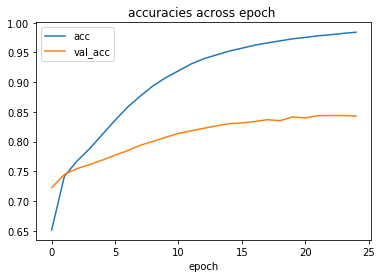

In [85]:
plt.plot(hist.epoch, hist.history['acc'], label = "acc")
plt.plot(hist.epoch, hist.history['val_acc'], label = "val_acc")
plt.xlabel('epoch')
plt.title('accuracies across epoch ')
plt.legend()
plt.show()

#### MODEL SELECTION ABSTRACT

We are utilizing Neural Network algorithm and Keras python library for building the model.
As we have large data (>150M observation), and other libraries and algorithm would succumb under these conditions.

In the process we have iterated across various 
    - NN architecture (SNN, single directional LSTM , Bidirectional LSTM, GRU), 
    - embedding (auto, Glove), 
    - regularization (L2) , 
    - auxilliary input ( different combination of drugname, condition, date & useful count )
    - hyperparameters (number of layers, training size, number of epochs). 

The most efficient combination of them all was choosen based on complexity, run-time & resourse requirements. This choosen architecture has 
    - layer of embedding of size 16
    - non-textual variable ( Useful Count) as auxilliary input
    - relu layer with 10 hidden neuron
    - softmax layer for 3 units

#### This gives us a training accuracy of 97% and test accuracy of 85%.



#### ITERATIONS ABSTRACT

- NN architecture : we iterated through various architecture, but the most simple ones gave the best results. 
The Single direction LSTM under performed as compared to SNN and took substantially longer to run. While Bidirectional LSTM was marginally better over single LSTM and GRU. This can be because the sentiment could be purely being driven by presence of certain keywords as compared to the position of these keywords.

- Embedding : Glove was deprioritised as it was resulting in large numbers of parameters for 1st layer
Various numbers of embedding dimention was tried, most of them gave similiar output, whith a elbow at 16. Hence 16 was choosen over others. Glove was tried but required more powerful machine to execute.

- Regularization : L2 regularization tested but was not effective
We ran L2 regularization with 3 rates (0.001,0.0001,0.0005), but none of these showed the desired results. Hence regularization step was removed in the final model
L1 and drop-out regularization was not tested as we had very few layers left in the model for a sparse kind of regularization to give a good results.

- Auxilliary input: Few non-textual data points was feed into the model after flatten layer.
The idea was to include these non textual provided features with the dataset. We tried various combinations of drugname (OneHotEncoding), condition(OneHotEncoding), date(year,month,weekday) & useful count. Obsereved that usage of only "usefulCount" feature gave a lift in accuracy of the existing model. Hence other features was not utilized in the final model.
Other features could have made better combination in some other forms ; this has been included in next steps.

- Hyperparamets: Lower number of layers / hidden unit performed better or similiar as compared to higher number of layers etc
As seen earlier a simple and small network gave better result as compared to complex and large architecture.
In the process we tried various numbers of - training size, layers, hidden units per layer and epochs.



#### NEXT STEPS

-1 The current framework is based on classification with 3 categories. 
We can also try to build a model with framework based on predicting absolute value ( regression ) with 1 to 10 rating as value output.
   
-2 In the current version, the auxilliary input contains direct features from the data.
We can create new variables by grouping names of drug. These groups/segments could be based on either the drug type / drug genre / drug usage. But this extension is subject to domain expertise and project time. 
Like Drug name, we can also create new variables by grouping condition. These groups/segments could be based on either broader level of condition, severity of condition etc. But again, this would be subject to domain expertise and project timelines. 
Including these new features can through some light on relation between drugname & condition with ratings which would be utilized in prediction.
    
-3 There are few words in the cleaned data which are not meaningful (in terms of dictionary). Eg erroneous text, emoticons as text etc. We can go ahead and manually remove these combination if they fall inside the 10000 vocab size.

-4 The training accurcay is higher ( more than 10% ) as compared to test/validation accuracy. One of the reasons for such scenarios is overfitting. Although we have tried L2 regularization and also that the test loss is not increasing ( but is either stable or decreasing ) in the span of 25 epoch; we can still try using drop-out regularization or L1 reqularization or include an attention layer or use KFold validation.

-5 The other reason why training accuracy is much higher as compared to test: presence of lots of unknown tokens. This could happen due to a) only 10M of the 80M variables were tokenized and hence rest 70k is unknown. b) the tested text has texts which are not present in the training sample. 
In such case, we can increase the number of tokens / vocabulary, and hence decrease the unknown tokens as much as possible.

-6 We can use GLOVE embedding. But since local system is not powerful enough to handle large numbers of parameters and we have time constraint, the current does not utilize Glove. The codes are provided below.



#### Saving Model & Tokenizer

In [ ]:
# saving model
model.save(param_mod['pkl_filename'])  # creates a HDF5 file 'my_model.h5'
# saving tokenizer
joblib.dump(tokenizer, param_mod['tok'])

#### Loading Model & Tokenizer

In [ ]:
# loading model 
pickle_model = load_model(param_prep['pkl_filename']) 
# loading tokenizer
tokenizer = joblib.load(param_prep['tok'])

#### Predict

In [ ]:
# predict model after creating the proper testing datasets from above
test_loss , test_acc = pickle_model.evaluate(x={'prim':  seq_padded_test , 'aux': test_aux }, y=label3_test , batch_size= 1024, verbose=2)
test_pred = pickle_model.predict( {'prim':  seq_padded_test , 'aux': test_aux } )

# Code for other algorithm used during iterations

## SNN with AUX input & L2 regularization

In [ ]:
"""
t = tp.time()
aux_input = tf.keras.Input(shape=(train_aux.shape[1],), name='aux')
prim_input = tf.keras.Input( shape =(param_prep['max_length'] ) , name='prim')
feat_embed = tf.keras.layers.Embedding(param_prep['vocab_size'] ,param_mod['embedding_dim'] , input_length = param_prep['max_length'] )(prim_input)
feat_flat = tf.keras.layers.Flatten()(feat_embed)
feat_con = tf.keras.layers.concatenate([feat_flat,aux_input])
feat_dens = tf.keras.layers.Dense(10, kernel_regularizer=regularizers.l2(0.001), activation = 'relu')(feat_con)
feat_sftm = tf.keras.layers.Dense(3,activation = 'softmax')(feat_dens)
model = tf.keras.Model(inputs=[prim_input, aux_input], outputs=[feat_sftm])
model.summary()

model.compile( loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
hist = model.fit({'prim': seq_padded ,'aux': train_aux } , label3, epochs = 50 ,
                  verbose = 2, batch_size = param_mod['training_size'], 
                  validation_data = ( {'prim':  seq_padded_test , 'aux': test_aux }, label3_test) )
t1 = tp.time() - t 
print ( "------------------------------------------------------------------------------------" , hist.history['acc'][-1]  , hist.history['val_acc'][-1] )
print ( int ( t1 / 60 ) , " minutes taken" )

plt.plot(hist.epoch, hist.history['acc'], label = "acc")
plt.plot(hist.epoch, hist.history['val_acc'], label = "val_acc")
plt.xlabel('epoch')
plt.title('accuracies across epoch ')
plt.legend()
plt.show()
"""

## Glove embedding

In [ ]:
"""
def embedding():
    embeddings_index = {}  
    f = open(os.path.join(param_mod['GLOVE_DIR'], param_mod['GLOVE_FILE'] ), "rb", buffering=0)
    #f = open(os.path.join(param_mod['GLOVE_DIR'], 'glove.840B.300d.txt'))              
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))

    embedding_matrix = np.zeros((len(word_index) + 1, param_mod['embedding_dim'] ))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = embedding ()
embedd_layer = Embedding(len(word_index) + 1, param_mod['embedding_dim'],
                            weights=[embedding_matrix], input_length=param_prep['max_length'], trainable=False)
seq_embedded = embedd_layer(seq_padded)
seq_embedded_test = embedd_layer(seq_padded_test)
"""

## Single LSTM with AUX input

In [ ]:
"""
t = tp.time()
aux_input = tf.keras.Input(shape=(1,), name='aux')
prim_input = tf.keras.Input( shape =(param_prep['max_length'] ) , name='prim')
feat_embed = tf.keras.layers.Embedding(param_prep['vocab_size'] ,param_mod['embedding_dim'] , input_length = param_prep['max_length'] )(prim_input)
feat_flat = tf.keras.layers.LSTM(10)(feat_embed)
feat_con = tf.keras.layers.concatenate([feat_flat,aux_input])
feat_dens = tf.keras.layers.Dense(20,activation = 'relu')(feat_con)
feat_sftm = tf.keras.layers.Dense(3,activation = 'softmax')(feat_dens)
model = tf.keras.Model(inputs=[prim_input, aux_input], outputs=[feat_sftm])
model.summary()

model.compile( loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
hist = model.fit({'prim': seq_padded ,'aux': train_raw['usefulCount'] } , label3, epochs = 20 ,
                  verbose = 2, batch_size = param_mod['training_size'], 
                  validation_data = ( {'prim':  seq_padded_test , 'aux': test_raw['usefulCount'] }, label3_test) )
t1 = tp.time() - t 
print ( int ( t1 / 60 ) , " minutes taken" )
"""

## DEEP LSTM (2 layers)

In [ ]:
"""
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(param_prep['vocab_size'] ,param_mod['embedding_dim'] , input_length = param_prep['max_length'] ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM (48, return_sequences = True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM (24)),
        tf.keras.layers.Dense(20,activation = 'relu'),
        tf.keras.layers.Dense(10,activation = 'softmax')
        ])
model.summary()
model.compile( loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
hist = model.fit(seq_padded, label, epochs = param_mod['epochs'] ,
                 validation_data = ( seq_padded_test, label_test) , 
                 verbose = 2, batch_size = param_mod['training_size'] )
                 """

## Single GRU

In [ ]:
"""
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(param_prep['vocab_size'] ,param_mod['embedding_dim'] , input_length = param_prep['max_length'] ),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU (48)),
        tf.keras.layers.Dense(20,activation = 'relu'),
        tf.keras.layers.Dense(10,activation = 'softmax')
        ])
model.summary()
model.compile( loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
hist = model.fit(seq_padded, label, epochs = param_mod['epochs'] ,
                 validation_data = ( seq_padded_test, label_test) , 
                 verbose = 2, batch_size = param_mod['training_size'] )
                 """

## Single LSTM

In [ ]:
"""
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(param_prep['vocab_size'] ,param_mod['embedding_dim'] , input_length = param_prep['max_length'] ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM (10)),
        tf.keras.layers.Dense(20,activation = 'relu'),
        tf.keras.layers.Dense(10,activation = 'softmax')
        ])
model.summary()
model.compile( loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
hist = model.fit(seq_padded, label, epochs = param_mod['epochs'] ,
                 validation_data = ( seq_padded_test, label_test) , 
                 verbose = 2, batch_size = param_mod['training_size'] )
                 """

## SNN

In [ ]:
"""
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(param_prep['vocab_size'] ,param_mod['embedding_dim'] , input_length = param_prep['max_length'] ),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(20,activation = 'relu'),
        tf.keras.layers.Dense(3,activation = 'softmax')
        ])
model.summary()

model.compile( loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
hist = model.fit(seq_padded, label3, epochs = param_mod['epochs'] ,
                 validation_data = ( seq_padded_test, label3_test) , 
                 verbose = 2, batch_size = param_mod['training_size'] )
"""